In [13]:
import torch
import torchvision

# Define the number of classes (including background)
num_classes = 14  # Change this to match the number of classes in your dataset

# Load Mask R-CNN model
model = torchvision.models.detection.maskrcnn_resnet50_fpn(pretrained=False)

# Modify the classifier head
in_features = model.roi_heads.box_predictor.cls_score.in_features
model.roi_heads.box_predictor = torchvision.models.detection.faster_rcnn.FastRCNNPredictor(in_features, num_classes)

# Modify the mask head
in_features_mask = model.roi_heads.mask_predictor.conv5_mask.in_channels
hidden_layer = 256
model.roi_heads.mask_predictor = torchvision.models.detection.mask_rcnn.MaskRCNNPredictor(in_features_mask, hidden_layer, num_classes)

# Load trained weights
model.load_state_dict(torch.load("/home/aiunika/Desktop/180_resnet/best_mask_rcnn.pth", map_location=torch.device("cpu")))

# Set model to evaluation mode
model.eval()



MaskRCNN(
  (transform): GeneralizedRCNNTransform(
      Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
      Resize(min_size=(800,), max_size=1333, mode='bilinear')
  )
  (backbone): BackboneWithFPN(
    (body): IntermediateLayerGetter(
      (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (bn1): FrozenBatchNorm2d(64, eps=1e-05)
      (relu): ReLU(inplace=True)
      (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (layer1): Sequential(
        (0): Bottleneck(
          (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn1): FrozenBatchNorm2d(64, eps=1e-05)
          (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn2): FrozenBatchNorm2d(64, eps=1e-05)
          (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn3): FrozenBatchNorm2d(256, eps=1e-05)
          (relu):

In [15]:
import json

# Path to your COCO JSON file
coco_json_path = "/home/aiunika/Desktop/180_resnet/180_4.v4-resnet.coco/train/_annotations.coco.json"

# Load the JSON file
with open(coco_json_path, 'r') as file:
    coco_data = json.load(file)

# Extract class names
class_names = {cat['id']: cat['name'] for cat in coco_data['categories']}
print("Extracted Class Names:", class_names)


Extracted Class Names: {0: 'ravelling', 1: 'CAUTIONARY-SIGN', 2: 'CRACK', 3: 'INFORMATORY-SIGN', 4: 'MAJOR-POTHOLE', 5: 'MANDATORY-SIGN', 6: 'MANHOLE', 7: 'MINOR-POTHOLE', 8: 'PEDESTRIAN-CROSSING', 9: 'ROAD-PATCH', 10: 'STREET-LIGHT', 11: 'TRAFFIC-LIGHT', 12: 'TREES'}


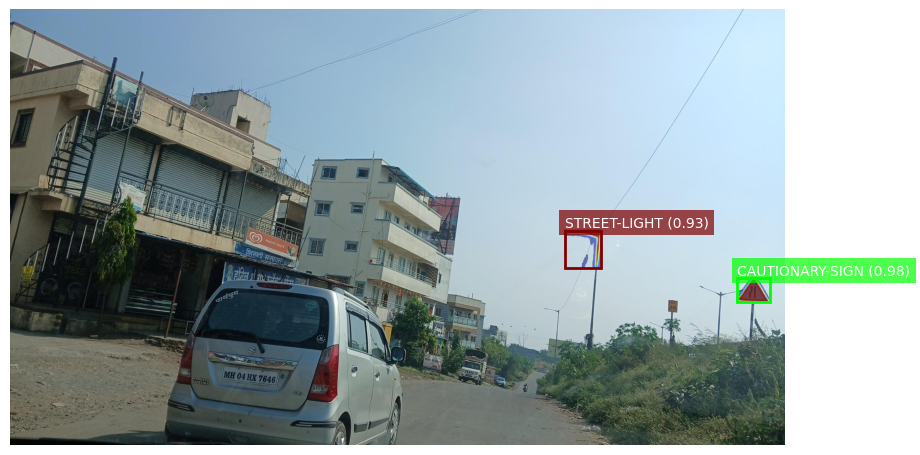

In [18]:
from PIL import Image
import torchvision.transforms as T
import matplotlib.pyplot as plt
import torch
import numpy as np

# Load the image
image_path = "/home/aiunika/Desktop/180_resnet/180_4.v4-resnet.coco/train/2024116_142944_123_jpg.rf.a955d1e50f9e0fed69e2ee03f4509b55.jpg"
image = Image.open(image_path).convert("RGB")

# Transform to tensor
transform = T.Compose([T.ToTensor()])
image_tensor = transform(image).unsqueeze(0)

# Run inference
model.eval()
with torch.no_grad():
    predictions = model(image_tensor)

# Extract results
boxes = predictions[0]['boxes'].cpu().numpy()
labels = predictions[0]['labels'].cpu().numpy()
scores = predictions[0]['scores'].cpu().numpy()
masks = predictions[0]['masks'].cpu().numpy()

# Score threshold
score_threshold = 0.5

# Define 13 distinct colors (RGB values between 0 and 1)
colors = [
    (1, 0, 0),  # Red
    (0, 1, 0),  # Green
    (0, 0, 1),  # Blue
    (1, 1, 0),  # Yellow
    (1, 0, 1),  # Magenta
    (0, 1, 1),  # Cyan
    (0.5, 0.5, 0.5),  # Gray
    (1, 0.5, 0),  # Orange
    (0.5, 0, 1),  # Purple
    (0, 0.5, 0.5),  # Teal
    (0.5, 0, 0),  # Dark Red
    (0, 0, 0.5),  # Navy Blue
    (0.5, 0.5, 0)  # Olive
]

# Assign colors to class labels (assuming 13 classes from 0 to 12)
class_colors = {i: colors[i] for i in range(13)}

# Visualize predictions
plt.figure(figsize=(10, 10))
plt.imshow(image)
plt.axis("off")

# Draw bounding boxes, masks, and class labels
for i, (box, label, score) in enumerate(zip(boxes, labels, scores)):
    if score >= score_threshold:
        class_name = class_names.get(label, f"Class_{label}")
        color = class_colors.get(label % 13, (1, 1, 1))  # Wrap around if more than 13 classes

        # Draw bounding box
        plt.gca().add_patch(plt.Rectangle(
            (box[0], box[1]), box[2] - box[0], box[3] - box[1],
            edgecolor=color, fill=False, linewidth=2
        ))

        # Draw mask with transparency
        mask = masks[i, 0]
        mask_resized = T.Resize(image.size[::-1])(T.ToPILImage()(mask))
        mask_array = np.array(mask_resized)
        plt.imshow(np.ma.masked_where(mask_array < 0.5, mask_array), alpha=0.5, cmap="jet")

        # Display class name and score
        plt.text(box[0], box[1] - 10, f"{class_name} ({score:.2f})", color="white",
                 bbox=dict(facecolor=color, alpha=0.7, edgecolor='none'))

plt.show()


In [ ]:
import torch
import torchvision.transforms as T
import cv2
import numpy as np
import matplotlib.pyplot as plt
from torchvision.models.detection import maskrcnn_resnet50_fpn
from PIL import Image

# Load Mask R-CNN model
model = maskrcnn_resnet50_fpn(pretrained=False, num_classes=14)  # Adjust num_classes if needed
model.load_state_dict(torch.load("best_mask_rcnn.pth"))
model.eval()

# Transform for input image
transform = T.Compose([T.ToTensor()])

# Initialize video capture
video_path = "input_video.mp4"
cap = cv2.VideoCapture(video_path)

# Video writer for output
output_path = "output_video.mp4"
fourcc = cv2.VideoWriter_fourcc(*"mp4v")
fps = int(cap.get(cv2.CAP_PROP_FPS))
width = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
height = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))
out = cv2.VideoWriter(output_path, fourcc, fps, (width, height))

# Assign random colors for 13 classes
np.random.seed(42)
colors = [np.random.randint(0, 255, size=3).tolist() for _ in range(14)]

# Class names (adjust based on your dataset)
class_names = {i: f"Class_{i}" for i in range(14)}  # Update class names if known

# Process each frame
while cap.isOpened():
    ret, frame = cap.read()
    if not ret:
        break

    # Convert frame to PIL Image for model input
    pil_image = Image.fromarray(cv2.cvtColor(frame, cv2.COLOR_BGR2RGB))
    image_tensor = transform(pil_image).unsqueeze(0)

    # Perform inference
    with torch.no_grad():
        predictions = model(image_tensor)

    # Extract predictions
    boxes = predictions[0]['boxes'].cpu().numpy()
    labels = predictions[0]['labels'].cpu().numpy()
    scores = predictions[0]['scores'].cpu().numpy()
    masks = predictions[0]['masks'].cpu().numpy()

    # Threshold for score
    score_threshold = 0.5

    for i, (box, label, score) in enumerate(zip(boxes, labels, scores)):
        if score >= score_threshold:
            color = colors[label % 14]
            class_name = class_names.get(label, f"Class_{label}")

            # Draw bounding box
            x1, y1, x2, y2 = box.astype(int)
            cv2.rectangle(frame, (x1, y1), (x2, y2), color, 2)

            # Add label and score
            label_text = f"{class_name} ({score:.2f})"
            cv2.putText(frame, label_text, (x1, y1 - 10), cv2.FONT_HERSHEY_SIMPLEX, 0.5, color, 2)

            # Apply mask to frame
            mask = masks[i, 0]
            mask = cv2.resize(mask, (frame.shape[1], frame.shape[0]))
            mask = (mask > 0.5).astype(np.uint8)

            # Color mask
            colored_mask = np.zeros_like(frame, dtype=np.uint8)
            colored_mask[:, :, 0] = mask * color[0]
            colored_mask[:, :, 1] = mask * color[1]
            colored_mask[:, :, 2] = mask * color[2]

            # Blend mask with frame
            frame = cv2.addWeighted(frame, 1, colored_mask, 0.5, 0)

    # Write the frame to output
    out.write(frame)

    # Display the frame (optional)
    cv2.imshow("Video", frame)
    if cv2.waitKey(1) & 0xFF == ord('q'):
        break

# Release resources
cap.release()
out.release()
cv2.destroyAllWindows()
